## 1. Import Packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc
import pickle
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn import set_config

## 2. Import data:

In [2]:
from sqlalchemy import create_engine

# Define connection parameters
server = r'DESKTOP-CBADVFM\SQLEXPRESS'  # Use raw string or double backslashes
database = 'DE_CAPSTONE_PROJECT'        # Database name without brackets

# Create connection string for Windows Authentication
connection_string = f'mssql+pyodbc://{server}/{database}?trusted_connection=yes&driver=SQL+Server'

# Create engine
engine = create_engine(connection_string)

In [3]:
final_table = pd.read_sql('select * from [dbo].[final_table]',engine,parse_dates=['hire_date','birth_date','last_date'])
final_table.sample(5)

,emp_no,first_name,last_name,birth_date,sex,emp_title_id,title,salary,no_of_departments,dept_nos,dept_names,hire_date,no_of_projects,Last_performance_rating,left,last_date
234027,247385,Francoise,Uchoa,1959-08-20,M,e0003,Senior Engineer,41183.0,1,d005,development,1990-12-02,4,C,False,NaT
43812,438120,Kazuhisa,Swen,1956-02-14,M,e0004,Technique Leader,51728.0,1,d005,development,1985-04-04,3,B,False,NaT
154558,92679,Sajjan,Dayang,1964-08-27,F,s0001,Staff,73635.0,1,d007,Sales,1992-09-04,8,C,False,NaT
260384,271346,Shigeaki,Jiang,1956-02-10,F,s0001,Staff,40000.0,1,d009,Customer Service,1998-04-02,5,B,False,NaT
142168,80289,Nahum,Pell,1958-07-04,F,e0003,Senior Engineer,54927.0,1,d005,development,1990-01-26,3,C,False,NaT


## 3. EDA:

In [6]:
final_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300024 entries, 0 to 300023
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   emp_no                   300024 non-null  object        
 1   first_name               300024 non-null  object        
 2   last_name                300024 non-null  object        
 3   birth_date               300024 non-null  datetime64[ns]
 4   sex                      300024 non-null  object        
 5   emp_title_id             300024 non-null  object        
 6   title                    300024 non-null  object        
 7   salary                   300024 non-null  float64       
 8   no_of_departments        300024 non-null  int64         
 9   dept_nos                 300024 non-null  object        
 10  dept_names               300024 non-null  object        
 11  hire_date                300024 non-null  datetime64[ns]
 12  no_of_projects  

In [9]:
max_last_date =pd.to_datetime(final_table['last_date']).max()
max_last_date

Timestamp('2013-03-10 00:00:00')

In [11]:
final_table['hire_date'] = pd.to_datetime(final_table['hire_date'])
final_table['last_date'] = pd.to_datetime(final_table['last_date'])

final_table['tenure'] = final_table['tenure'] = (
    (final_table['last_date'].fillna(max_last_date) - final_table['hire_date']).dt.days / 365
)
final_table.sample(5)

,emp_no,first_name,last_name,birth_date,sex,emp_title_id,title,salary,no_of_departments,dept_nos,dept_names,hire_date,no_of_projects,Last_performance_rating,left,last_date,tenure
273834,283573,Martine,Flanders,1952-11-11,M,s0002,Senior Staff,44052.0,2,"d007, d009","Sales, Customer Service",1992-11-14,5,C,False,NaT,20.331507
90662,480711,Srinidhi,Assaf,1954-04-21,M,s0001,Staff,83125.0,1,d007,Sales,1988-02-07,10,S,False,NaT,25.104110
32509,427845,Franziska,Murillo,1955-04-19,M,e0002,Engineer,48972.0,1,d005,development,1985-04-30,9,C,False,NaT,27.879452
272205,282092,Masasuke,Pehl,1954-06-16,M,e0003,Senior Engineer,60334.0,1,d005,development,1988-05-14,9,B,False,NaT,24.838356
259186,270257,Jaewoo,Kirkerud,1960-01-18,M,s0002,Senior Staff,40000.0,1,d009,Customer Service,1991-06-13,6,PIP,False,NaT,21.756164


In [13]:
final_table['birth_date'] = pd.to_datetime(final_table['birth_date'])
final_table['last_date'] = pd.to_datetime(final_table['last_date'])
final_table['age'] = ((final_table['last_date'].fillna(max_last_date) - final_table['birth_date']).dt.days / 365
)
final_table.sample(5)

,emp_no,first_name,last_name,birth_date,sex,emp_title_id,title,salary,no_of_departments,dept_nos,dept_names,hire_date,no_of_projects,Last_performance_rating,left,last_date,tenure,age
112074,50195,Zongyan,Waymire,1958-07-07,F,e0004,Technique Leader,53502.0,2,"d005, d008","development, Research",1986-05-01,2,B,False,NaT,26.876712,54.712329
16729,41350,Olivera,Ratnakar,1953-12-09,F,e0001,Assistant Engineer,40352.0,1,d004,Production,1994-11-07,7,A,False,NaT,18.350685,59.290411
38751,43352,Luise,Schiettecatte,1964-09-02,F,e0003,Senior Engineer,43116.0,2,"d004, d006","Production, Quality Management",1989-04-28,4,B,False,NaT,23.882192,48.550685
14857,411798,Abdelaziz,Zschoche,1957-01-28,M,e0001,Assistant Engineer,45064.0,1,d004,Production,1993-04-18,1,B,False,NaT,19.906849,56.150685
286684,295255,Jacopo,Bellone,1965-01-04,M,e0004,Technique Leader,42789.0,1,d004,Production,1988-03-13,9,C,False,NaT,25.008219,48.210959


In [15]:
final_table['tenure'] = (final_table['tenure'] * 12).round().astype(int)

In [17]:
final_table.tenure.max()

338

In [19]:
final_table.tenure.min()

16

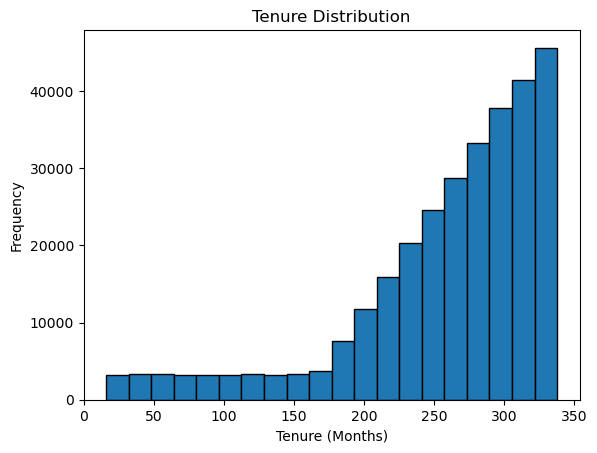

In [21]:
plt.hist(final_table['tenure'], bins=20, edgecolor='black')
plt.xlabel("Tenure (Months)")
plt.ylabel("Frequency")
plt.title("Tenure Distribution")
plt.show()

In [23]:
skewness = skew(final_table['tenure'])
print("Skewness:", skewness)

Skewness: -1.4736073636020948


In [25]:
final_table['age'] = final_table['age'].round().astype(int)
final_table.sample(5)

,emp_no,first_name,last_name,birth_date,sex,emp_title_id,title,salary,no_of_departments,dept_nos,dept_names,hire_date,no_of_projects,Last_performance_rating,left,last_date,tenure,age
226990,240988,Weidon,Flasterstein,1953-06-24,F,e0003,Senior Engineer,52688.0,1,d005,development,1988-10-22,10,C,False,NaT,293,60
237419,250469,Toong,Mullainathan,1964-05-09,M,e0004,Technique Leader,67906.0,1,d004,Production,1988-08-15,7,B,False,NaT,295,49
107906,496388,Sarita,Axelband,1952-09-01,M,e0002,Engineer,77721.0,1,d004,Production,1986-12-01,6,B,False,NaT,315,61
162762,100803,Noritoshi,Bernick,1957-12-27,F,s0002,Senior Staff,50253.0,1,d002,Finance,1995-06-13,3,S,False,NaT,213,55
116079,54200,Xudong,Bratten,1958-03-13,M,s0001,Staff,80636.0,1,d007,Sales,1988-04-26,7,B,False,NaT,299,55


In [27]:
final_table.age.max()

61

In [29]:
final_table.age.min()

22

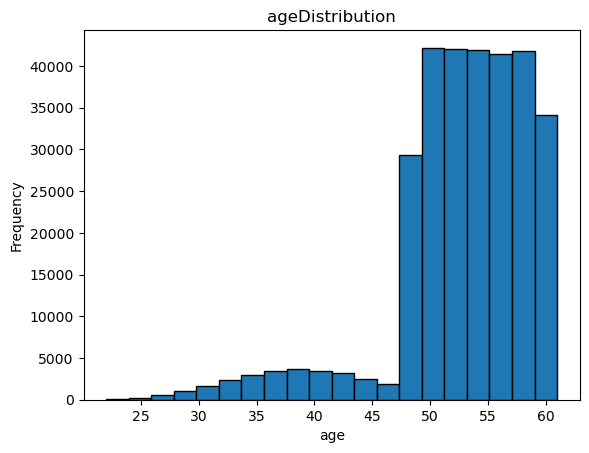

In [31]:
plt.hist(final_table['age'], bins=20, edgecolor='black')
plt.xlabel("age")
plt.ylabel("Frequency")
plt.title("ageDistribution")
plt.show()

In [33]:
skewness = skew(final_table['age'])
print("Skewness:", skewness)

Skewness: -1.5724469032098656


In [35]:
final_table.isnull().sum()

emp_no                          0
first_name                      0
last_name                       0
birth_date                      0
sex                             0
emp_title_id                    0
title                           0
salary                          0
no_of_departments               0
dept_nos                        0
dept_names                      0
hire_date                       0
no_of_projects                  0
Last_performance_rating         0
left                            0
last_date                  270157
tenure                          0
age                             0
dtype: int64

In [37]:
final_table.duplicated().sum()

0

In [39]:
final_table.to_excel('new_table1.xlsx',index=False)

In [193]:
final_table['left'] = final_table['left'].astype(int)

In [196]:
final_table_numeric = final_table.select_dtypes(include=['number'])  # Keep only numeric columns
correlation_with_left = final_table_numeric.corr()['left']
correlation_with_left

salary              -0.005035
no_of_departments    0.000376
no_of_projects       0.003164
left                 1.000000
tenure              -0.797822
age                 -0.753562
Name: left, dtype: float64

In [198]:
x = final_table.drop(columns=['left'])

y = final_table['left']

In [200]:
x.drop(columns=['emp_no','first_name','last_name','emp_title_id','dept_nos','birth_date','last_date','hire_date'],inplace=True)

In [202]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300024 entries, 0 to 300023
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   sex                      300024 non-null  object 
 1   title                    300024 non-null  object 
 2   salary                   300024 non-null  float64
 3   no_of_departments        300024 non-null  int64  
 4   dept_names               300024 non-null  object 
 5   no_of_projects           300024 non-null  int64  
 6   Last_performance_rating  300024 non-null  object 
 7   tenure                   300024 non-null  int32  
 8   age                      300024 non-null  int32  
dtypes: float64(1), int32(2), int64(2), object(4)
memory usage: 18.3+ MB


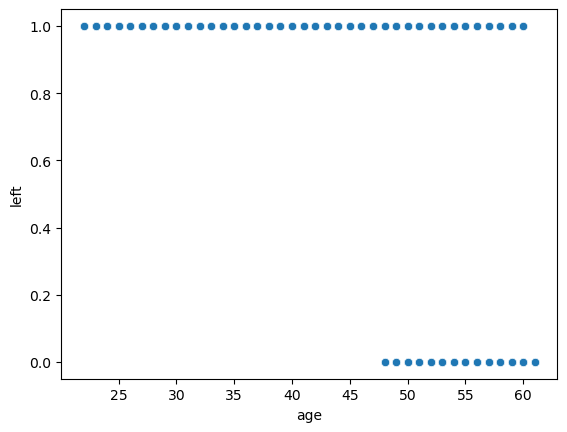

In [204]:
sns.scatterplot(x=final_table['age'],y=final_table['left'])
plt.show()

## 4. Building the Model:

Important Features: ['cat__ordinal_tenure__tenure_category', 'cat__ordinal_age__age_group', 'cat__onehot_others__title_Senior Engineer', 'cat__onehot_others__title_Staff', 'cat__onehot_others__title_Senior Staff', 'cat__onehot_others__dept_names_Production, Customer Service', 'cat__onehot_others__dept_names_Quality Management', 'cat__onehot_others__title_Technique Leader', 'cat__onehot_others__dept_names_Production', 'cat__onehot_others__dept_names_development', 'cat__onehot_others__dept_names_Production, Quality Management', 'cat__onehot_others__dept_names_Marketing, Customer Service', 'cat__onehot_others__dept_names_Marketing, Sales', 'cat__onehot_others__dept_names_Production, development']


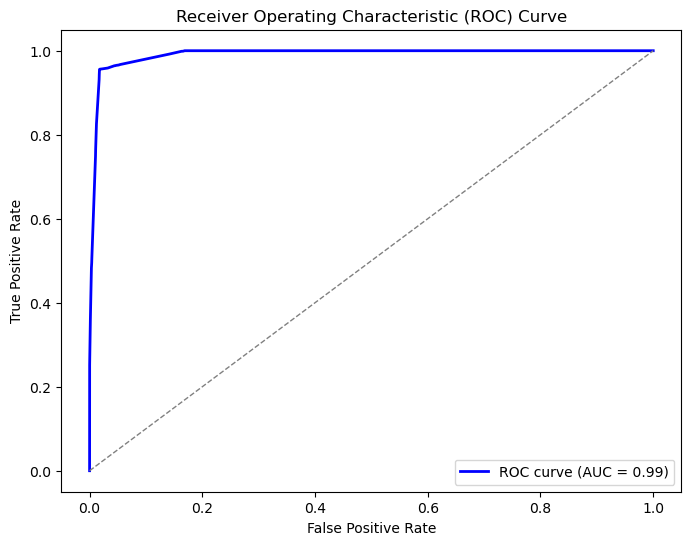

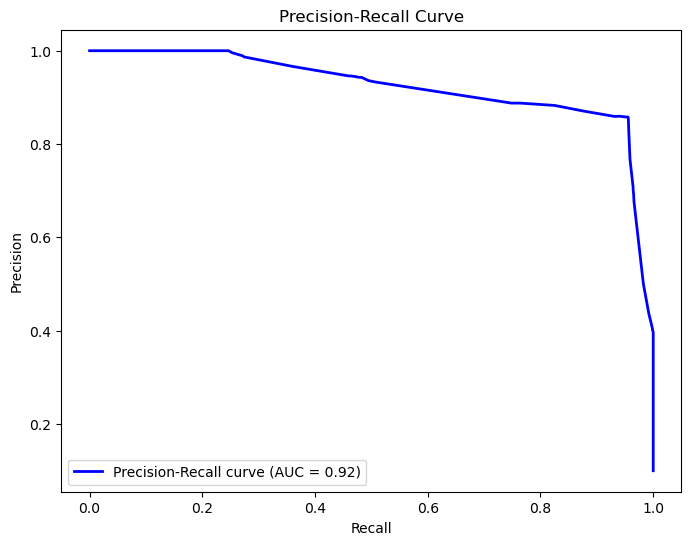

Accuracy: 0.9797516873593867
Confusion Matrix:
 [[53066   948]
 [  267  5724]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     54014
           1       0.86      0.96      0.90      5991

    accuracy                           0.98     60005
   macro avg       0.93      0.97      0.95     60005
weighted avg       0.98      0.98      0.98     60005

ROC-AUC Score: 0.9908632727914646
Precision-Recall AUC Score: 0.9239749480945876
Fitting 5 folds for each of 20 candidates, totalling 100 fits


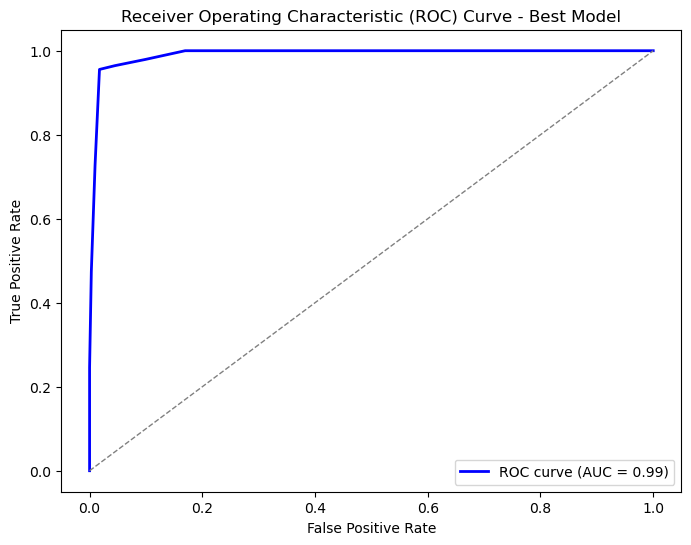

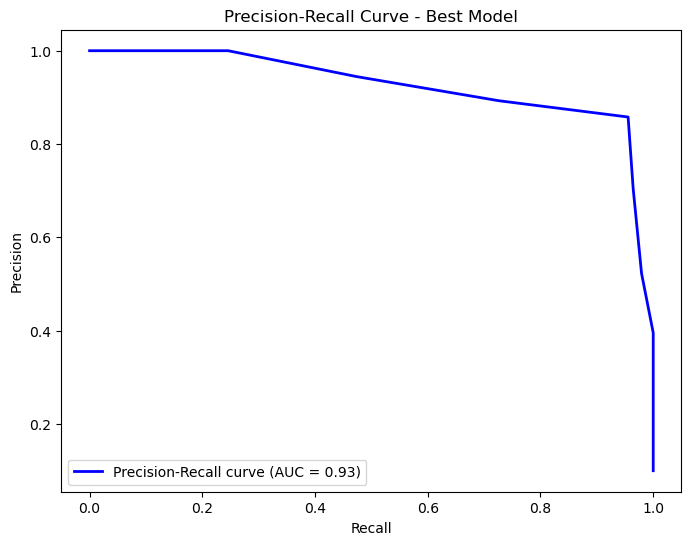

Best Parameters: {'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__class_weight': None, 'model__C': 0.01}
Accuracy: 0.9797516873593867
Confusion Matrix:
 [[53066   948]
 [  267  5724]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     54014
           1       0.86      0.96      0.90      5991

    accuracy                           0.98     60005
   macro avg       0.93      0.97      0.95     60005
weighted avg       0.98      0.98      0.98     60005

ROC-AUC Score: 0.9907844851910244
Precision-Recall AUC Score: 0.9256634087054032
Cross-validation accuracy scores: [0.97948088 0.97914757 0.97935589 0.9787726  0.97825136]
Mean accuracy: 0.9790016592423936


In [210]:

# Step 1: Split the Data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Step 2: Feature Engineering
# Create tenure_category based on percentiles
percentiles_app = X_train['tenure'].quantile([0, 0.25, 0.5, 0.75, 1]).tolist()
X_train['tenure_category'] = pd.cut(X_train['tenure'], bins=percentiles_app, labels=['Low', 'Medium', 'High', 'Very High'], include_lowest=True)
X_test['tenure_category'] = pd.cut(X_test['tenure'], bins=percentiles_app, labels=['Low', 'Medium', 'High', 'Very High'], include_lowest=True)

# Create age_group based on bins
bins = [20, 35, 50, float('inf')]
labels = ['20-35', '35-50', '50+']
X_train['age_group'] = pd.cut(X_train['age'], bins=bins, labels=labels, right=False)
X_test['age_group'] = pd.cut(X_test['age'], bins=bins, labels=labels, right=False)

# Step 3: Drop Unnecessary Columns
columns_to_remove = ['tenure', 'age']
X_train.drop(columns=columns_to_remove, inplace=True)
X_test.drop(columns=columns_to_remove, inplace=True)

# Step 4: Define the Preprocessing Pipeline
# Identify categorical and numerical features
categorical_features = ['Last_performance_rating', 'sex', 'dept_names', 'title', 'tenure_category', 'age_group']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

# Preprocessing for categorical data
categorical_transformer = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=[['PIP', 'C', 'B', 'S', 'A']]), ['Last_performance_rating']),
        ('onehot_gender', OneHotEncoder(sparse_output=False, drop='first', categories=[['M', 'F']]), ['sex']),
        ('onehot_others', OneHotEncoder(sparse_output=False, drop='first'), ['dept_names', 'title']),
        ('ordinal_tenure', OrdinalEncoder(categories=[['Low', 'Medium', 'High', 'Very High']]), ['tenure_category']),
        ('ordinal_age', OrdinalEncoder(categories=[['20-35', '35-50', '50+']]), ['age_group'])
    ],
    remainder='passthrough'
)

# Preprocessing for numerical data (scaling)
numerical_transformer = StandardScaler()

# Combine preprocessing steps
transformer_app = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

# Step 5: Transform the Data
X_train_transformed = transformer_app.fit_transform(X_train)
X_test_transformed = transformer_app.transform(X_test)

# Step 6: Create DataFrames from Transformed Data
feature_names = transformer_app.get_feature_names_out()
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Step 7: Resampling
smote = SMOTE(sampling_strategy=0.5, random_state=42)
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)

# Step 8: Train a Baseline Model for Feature Importance
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train_transformed_df, y_train)

# Step 9: Calculate Feature Importance (Absolute Coefficients)
feature_importances = np.abs(baseline_model.coef_[0])  # Use absolute coefficients as importance
importance_df = pd.DataFrame({'Feature': X_train_transformed_df.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 10: Filter Features Based on Importance
threshold = 0.2  
important_features_app = importance_df[importance_df['Importance'] > threshold]['Feature'].tolist()
X_train_filtered = X_train_transformed_df[important_features_app]
X_test_filtered = X_test_transformed_df[important_features_app]
print('Important Features:', important_features_app)

# Step 11: Define the Final Model
model = LogisticRegression(random_state=42, max_iter=1000)

# Step 12: Define the Resampling and Modeling Pipeline
pipeline = ImbPipeline([
    ('smote', smote),
    ('undersampler', undersampler),
    ('model', model)
])

set_config(display='diagram')
pipeline

# Step 13: Fit the Pipeline on Filtered Data
pipeline.fit(X_train_filtered, y_train)

# Step 14: Evaluate the Pipeline
y_pred = pipeline.predict(X_test_filtered)
y_pred_proba = pipeline.predict_proba(X_test_filtered)[:, 1]  # Probabilities for the positive class

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate precision-recall curve and AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc)
print("Precision-Recall AUC Score:", pr_auc)

# Step 15: Hyperparameter Tuning
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'model__penalty': ['l1', 'l2'],  # Regularization type
    'model__solver': ['liblinear'],  # Solver for logistic regression
    'model__class_weight': [None, 'balanced']  # Class weights
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=5, verbose=2, n_jobs=-1, random_state=42, n_iter=20)
random_search.fit(X_train_filtered, y_train)

# Step 16: Evaluate the Best Model
best_model_app = random_search.best_estimator_
y_pred = best_model_app.predict(X_test_filtered)
y_pred_proba = best_model_app.predict_proba(X_test_filtered)[:, 1]  # Probabilities for the positive class

# Calculate ROC curve and AUC score for the best model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve for the best model
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Best Model')
plt.legend(loc='lower right')
plt.show()

# Calculate precision-recall curve and AUC for the best model
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Plot precision-recall curve for the best model
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Best Model')
plt.legend(loc='lower left')
plt.show()

print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc)
print("Precision-Recall AUC Score:", pr_auc)

# Step 17: Cross-Validation
cv_scores = cross_val_score(best_model_app, X_train_filtered, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean()}")

## Save the model:

In [212]:
    import joblib
    import os

    # Ensure the variables are defined and not None
    if best_model_app is not None:
        joblib.dump(best_model_app, 'best_model_app.joblib')
        print("best_mode_app.joblib saved successfully.")
    else:
        print("best_model_app is None or not defined.")
    
    if transformer_app is not None:
        joblib.dump(transformer_app, 'transformer_app.joblib')
        print("transformer_app.joblib saved successfully.")
    else:
        print("transformer_app is None or not defined.")
    
    if important_features_app is not None:
        joblib.dump(important_features_app, 'important_features_app.joblib')
        print("important_features_app.joblib saved successfully.")
    else:
        print("important_features_app is None or not defined.")
    
    if percentiles_app is not None:
        joblib.dump(percentiles_app, 'percentiles_app.joblib')
        print("percentiles_app.joblib saved successfully.")
    else:
        print("percentiles_app is None or not defined.")
    
    # Check if files were created
    files = ['best_model_app.joblib', 'transformer_app.joblib', 'important_features_app.joblib', 'percentiles_app.joblib']
    for file in files:
        if os.path.exists(file):
            print(f"{file} exists.")
        else:
            print(f"{file} does not exist.")

best_mode_app.joblib saved successfully.
transformer_app.joblib saved successfully.
important_features_app.joblib saved successfully.
percentiles_app.joblib saved successfully.
best_model_app.joblib exists.
transformer_app.joblib exists.
important_features_app.joblib exists.
percentiles_app.joblib exists.
